In [1]:
import numpy as np, matplotlib.pyplot as plt
from astropy.io import fits
from photutils.isophote import Ellipse
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture, SkyCircularAperture, CircularAperture, aperture_photometry, ApertureStats
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
import seaborn as sns
from astropy.stats import sigma_clipped_stats
import warnings
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
warnings.filterwarnings("ignore")
import pandas as pd
from astropy.table import Table
from astropy import coordinates
from astropy.nddata import Cutout2D
from astropy.cosmology import WMAP9 as cosmo
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from matplotlib.patches import Rectangle

plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['image.origin'] = 'lower'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context('talk') 
sns.set(font_scale=2.2)
sns.set_palette('colorblind')
sns.set_style('ticks')

plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']

# Configure math text to use the sans-serif font
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'sans'
plt.rcParams['mathtext.it'] = 'sans:italic'
plt.rcParams['mathtext.bf'] = 'sans:bold'

plt.rcParams['pdf.fonttype']=42 

# standard imports for my work
from bpt_utils import *
from read_transients_data import *
from correct_redshift_evolution import *
from generate_bkg_galaxies import *
from helper_functions import *


/Users/krittisharma/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
large_host_sample = read_dsa_data(only_gold=False)
frbs = list(large_host_sample["frb_name"])
redshifts = list(large_host_sample["redshift"])
img_names = [large_host_sample["P_host"][i].split(" ")[0].replace("BASS", "Legacy")+".fits" for i in range(len(large_host_sample))]
frbs = ['mark', 'mizu', 'zach', 'jackie', 'leonidas',
        'elektra', 'tildis', 'etienne', 'nina', 'ansel',
        'alex', 'isha', 'squanto', 'phineas', 'charlotte',
        'juan', 'oran', 'mikayla', 'fatima', 'ishita',
        'gertrude', 'erdos', 'fen', 'pingu', 'whitney',
        'ferb', 'koyaanisqatsi', 'nihari', 'quincy', 'mifanshan']
cutout_sizes = [250, 250, 190, 140, 140, 
                140, 140, 140, 140, 120, 
                80, 80, 80, 120, 120, 
                80, 100, 110, 80, 80, 
                90, 90, 90, 70, 70, 
                80, 80, 70, 70, 70]
physical_sizes = [2, 5, 5, 5, 5, 
                  5, 5, 5, 10, 10, 
                  10, 10, 10, 10, 10, 
                  10, 10, 10, 10, 10, 
                  10, 10, 10, 10, 10, 
                  10, 10, 10, 10, 10]
mins = [0, 0, 0, -1, -2, 
        -2, -1, -1, -1, -1, 
        -1, -1, -1, -1, -1, 
        -1, -1, -1, -1, -1, 
        -1, -1, -1, -1, -1, 
        -1, -1, -1, -1, -1]
maxs = [8, 60, 10, 140, 10, 
        10, 20, 25, 10, 7, 
        7, 4, 4, 20, 10, 
        20, 8, 3, 10, 3, 
        4, 4, 3, 5, 4, 
        5, 4, 5, 5, 2]

pixel_scales = {"BASS/r": 0.2637,
                "PS1/r": 0.258,
                "WASP/r": 0.18,
                "WIRC/J": 0.2487,
                "DEIMOS/R": 0.1185,
                "LRIS/R": 0.135
               }

gauss_kernel_width = 0.15
fontsize = 13

100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.05it/s]


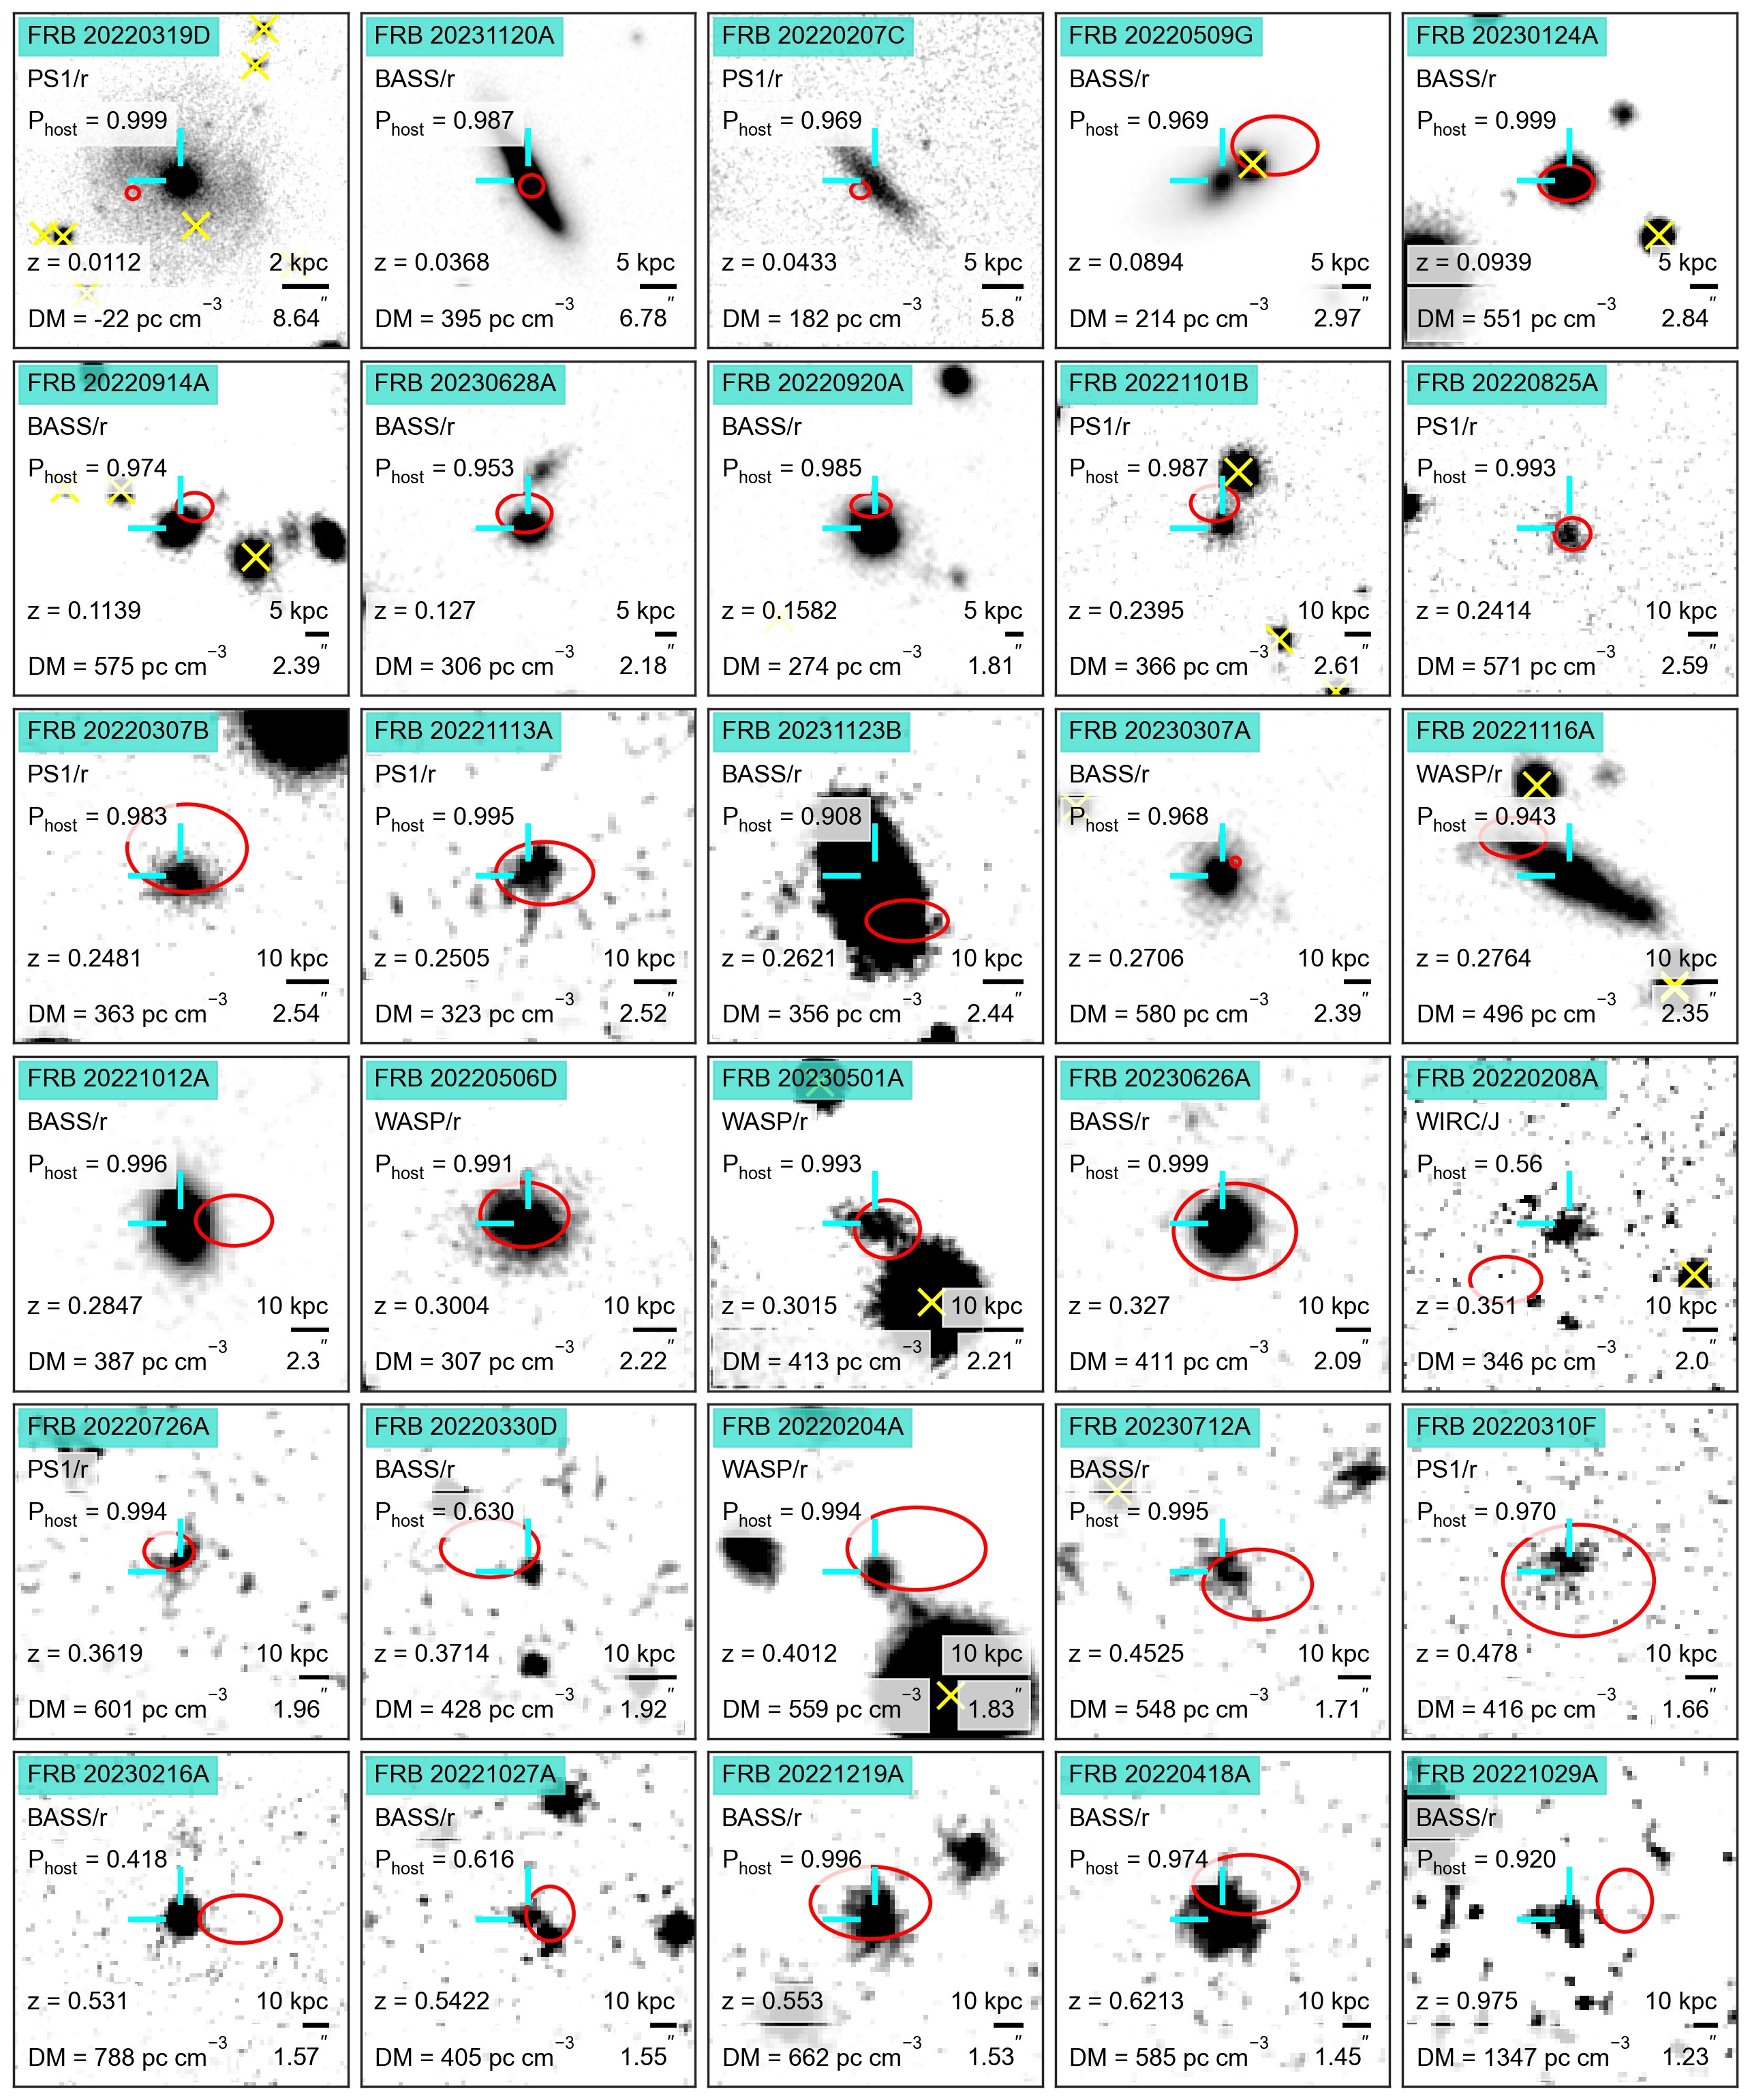

In [3]:
fig, axes = plt.subplots(6, 5, figsize=(3.2*6, 3.2*5))

from tqdm import tqdm

for k in tqdm(range(len(frbs))):
    idx1 = k//5
    idx2 = (k-idx1*5)
    frb = frbs[k]
    img = img_names[k]
    img_loc = "/Users/krittisharma/Desktop/research/frb_hosts/sed_fits_v2/{}/{}".format(frb, img)
    cutout_size = cutout_sizes[k]
    physical_size = physical_sizes[k]
    
    pos, e_ra, e_dec = get_ra_dec_errs(frb)
    df = large_host_sample[large_host_sample["frb_name"]==frb].reset_index()

    host_pos = SkyCoord(df["host_loc (hms, dms)"][0].split(", ")[0], 
                        df["host_loc (hms, dms)"][0].split(", ")[1], 
                        unit=(u.hourangle, u.deg), frame='icrs')

    if "Legacy" in img_loc:
        idx = 1
    else:
        idx = 0
    data = fits.open(img_loc)[idx].data
    hdr = fits.open(img_loc)[idx].header
    wcs = WCS(hdr)
    x0, y0 = wcs.world_to_pixel(host_pos)
    
    cutout = Cutout2D(data, position=(x0, y0), size=(cutout_size, cutout_size), wcs=wcs)
    data = cutout.data
    if frb in ["isha", "gertrude", "erdos", "mifanshan"]:
        factor=2
    else:
        factor=1
    gauss_kernel = Gaussian2DKernel(factor*gauss_kernel_width/pixel_scales[df["P_host"][0].split(" ")[0]])
    data = convolve(data, gauss_kernel)
    wcs2 = cutout.wcs
    
    z = df["redshift"][0]
    DM = get_DMexgal(frb)
    
    _, median, sigma = sigma_clipped_stats(data)
    axes[idx1, idx2].imshow(data, vmin = median-mins[k]*sigma, vmax=median+maxs[k]*sigma, origin='lower', cmap="gray_r")
    
    axes[idx1, idx2].text(.04, .93, '{}'.format(df["FRB_TNS_name"][0]), color="black", ha='left', va='center',
                          bbox=dict(facecolor='turquoise', edgecolor='turquoise', alpha=0.8), 
                          transform=axes[idx1, idx2].transAxes, fontsize=fontsize)
    
    axes[idx1, idx2].text(.04, .8, df["P_host"][0].split(" ")[0], bbox=dict(facecolor='white', edgecolor='white', alpha=0.8), 
                          color="black", ha='left', va='center', transform=axes[idx1, idx2].transAxes, fontsize=fontsize)
    
    axes[idx1, idx2].text(.04, .67, "P{} = {}".format(r"$_{{\mathrm{host}}}$", df["P_host"][0].split(" ")[1]), 
                          bbox=dict(facecolor='white', edgecolor='white', alpha=0.8), color="black", ha='left', va='center', 
                          transform=axes[idx1, idx2].transAxes, fontsize=fontsize)
    
    axes[idx1, idx2].text(.04, .25, 'z = {}'.format(round(float(z), 4)), bbox=dict(facecolor='white', edgecolor='white', alpha=0.8), 
                          color="black", ha='left', va='center', transform=axes[idx1, idx2].transAxes, fontsize=fontsize)
    
    axes[idx1, idx2].text(.04, .1, 'DM{} = {} pc cm{}'.format(r"", int(DM), r"$^{-3}$"), 
                          bbox=dict(facecolor='white', edgecolor='white', alpha=0.8), color="black", 
                          ha='left', va='center', transform=axes[idx1, idx2].transAxes, fontsize=fontsize)
    
    physical_size_in_pix = (physical_size/(cosmo.angular_diameter_distance(z).value*1e3))*(180/3.14)*3600/(pixel_scales[df["P_host"][0].split(" ")[0]]*cutout_size)
    physical_size_in_arcsec = physical_size_in_pix*cutout_size*pixel_scales[df["P_host"][0].split(" ")[0]]
    
    axes[idx1, idx2].text(0.94, 0.25, '{} kpc'.format(physical_size), bbox=dict(facecolor='white', edgecolor='white', alpha=0.8), 
                          color="black", ha='right', va='center', transform=axes[idx1, idx2].transAxes, fontsize=fontsize)
    
    axes[idx1, idx2].text(0.94, 0.1, '{}{}'.format(round(physical_size_in_arcsec, 2), r"$^{\prime\prime}$"),
                          bbox=dict(facecolor='white', edgecolor='white', alpha=0.8), color="black", ha='right', 
                          va='center', transform=axes[idx1, idx2].transAxes, fontsize=fontsize)
    
    r = Rectangle((0.94, 0.18), 
                  0.01, physical_size_in_pix,
                  fill=True, alpha=1, angle=90, 
                  edgecolor='black', facecolor='black', 
                  transform=axes[idx1, idx2].transAxes)
    axes[idx1, idx2].add_patch(r)
    
    x1, y1 = wcs2.world_to_pixel(pos[0])
    aper = EllipticalAperture((x1, y1), e_ra*2.15/pixel_scales[df["P_host"][0].split(" ")[0]], e_dec*2.15/pixel_scales[df["P_host"][0].split(" ")[0]], 0)
    aper.plot(ax=axes[idx1, idx2], color='red', linewidth=2)
    
    axes[idx1, idx2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axes[idx1, idx2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    axes[idx1, idx2].scatter(0.5, 0.6, marker='|', s=400, color="cyan", lw=3, transform=axes[idx1, idx2].transAxes)
    axes[idx1, idx2].scatter(0.4, 0.5, marker='_', s=400, color="cyan", lw=3, transform=axes[idx1, idx2].transAxes)

    if frb == "mark":
        ra_stars = [32.1891387, 32.1922274, 32.1854077, 32.1679013, 32.1521978, 32.1582054, 32.1567894, 32.1523214]
        dec_stars = [71.0330333, 71.0331092, 71.0300763, 71.0335400, 71.0314834, 71.0418271, 71.0437512, 71.0314837]
    if frb == "jackie":
        ra_stars = [282.6720185]
        dec_stars = [70.2432902]
    if frb == "leonidas":
        ra_stars = [231.907645]
        dec_stars = [70.9665]
    if frb == "elektra":
        ra_stars = [282.0503519, 282.06461045829553, 282.070605176802]
        dec_stars = [73.3353870, 73.33743602118378, 73.3375085356836]
    if frb == "etienne":
        ra_stars = [240.265736]
        dec_stars = [70.915391]
    if frb == "nina":
        ra_stars = [342.214353260, 342.209786310, 342.204477960]
        dec_stars = [70.682127620, 70.677343230, 70.675931590]
    if frb == "phineas":
        ra_stars = [177.794584]
        dec_stars = [71.697107]
    if frb == "charlotte":
        ra_stars = [21.200656245591837, 21.20066044008219, 21.208829057891798]
        dec_stars = [72.65123775014496, 72.65129824851184, 72.65484051430383]
    if frb == "mikayla":
        ra_stars = [340.02497759391736, 340.03050211139]
        dec_stars = [70.92099789504195, 70.92455695483606]
    if frb == "ishita":
        ra_stars = [322.56601042001046]
        dec_stars = [70.0411220034963]
    if frb == "fen":
        ra_stars = [274.22496255774314]
        dec_stars = [69.72056136592256]
    if frb == "pingu":
        ra_stars = [167.3657]
        dec_stars = [72.559212]

    if frb in ["mark", "jackie", "leonidas", "elektra", "etienne", "nina", "phineas", "charlotte", "mikayla", "ishita", "fen", "pingu"]:
        for i in range(len(ra_stars)):
            pos = SkyCoord(ra_stars[i], dec_stars[i], unit=(u.deg, u.deg), frame='icrs')
            x1, y1 = wcs2.world_to_pixel(pos)
            axes[idx1, idx2].scatter(x1, y1, marker='x', color="yellow", s=200, lw=2)

fig.tight_layout()

plt.subplots_adjust(wspace=-0.69, hspace=0.04)

plt.savefig("/Users/krittisharma/Desktop/research/frb_hosts/sed_fits_v3/dynesty/figures/host_cutouts_combined.jpeg",
            dpi=400,
            bbox_inches = 'tight')
